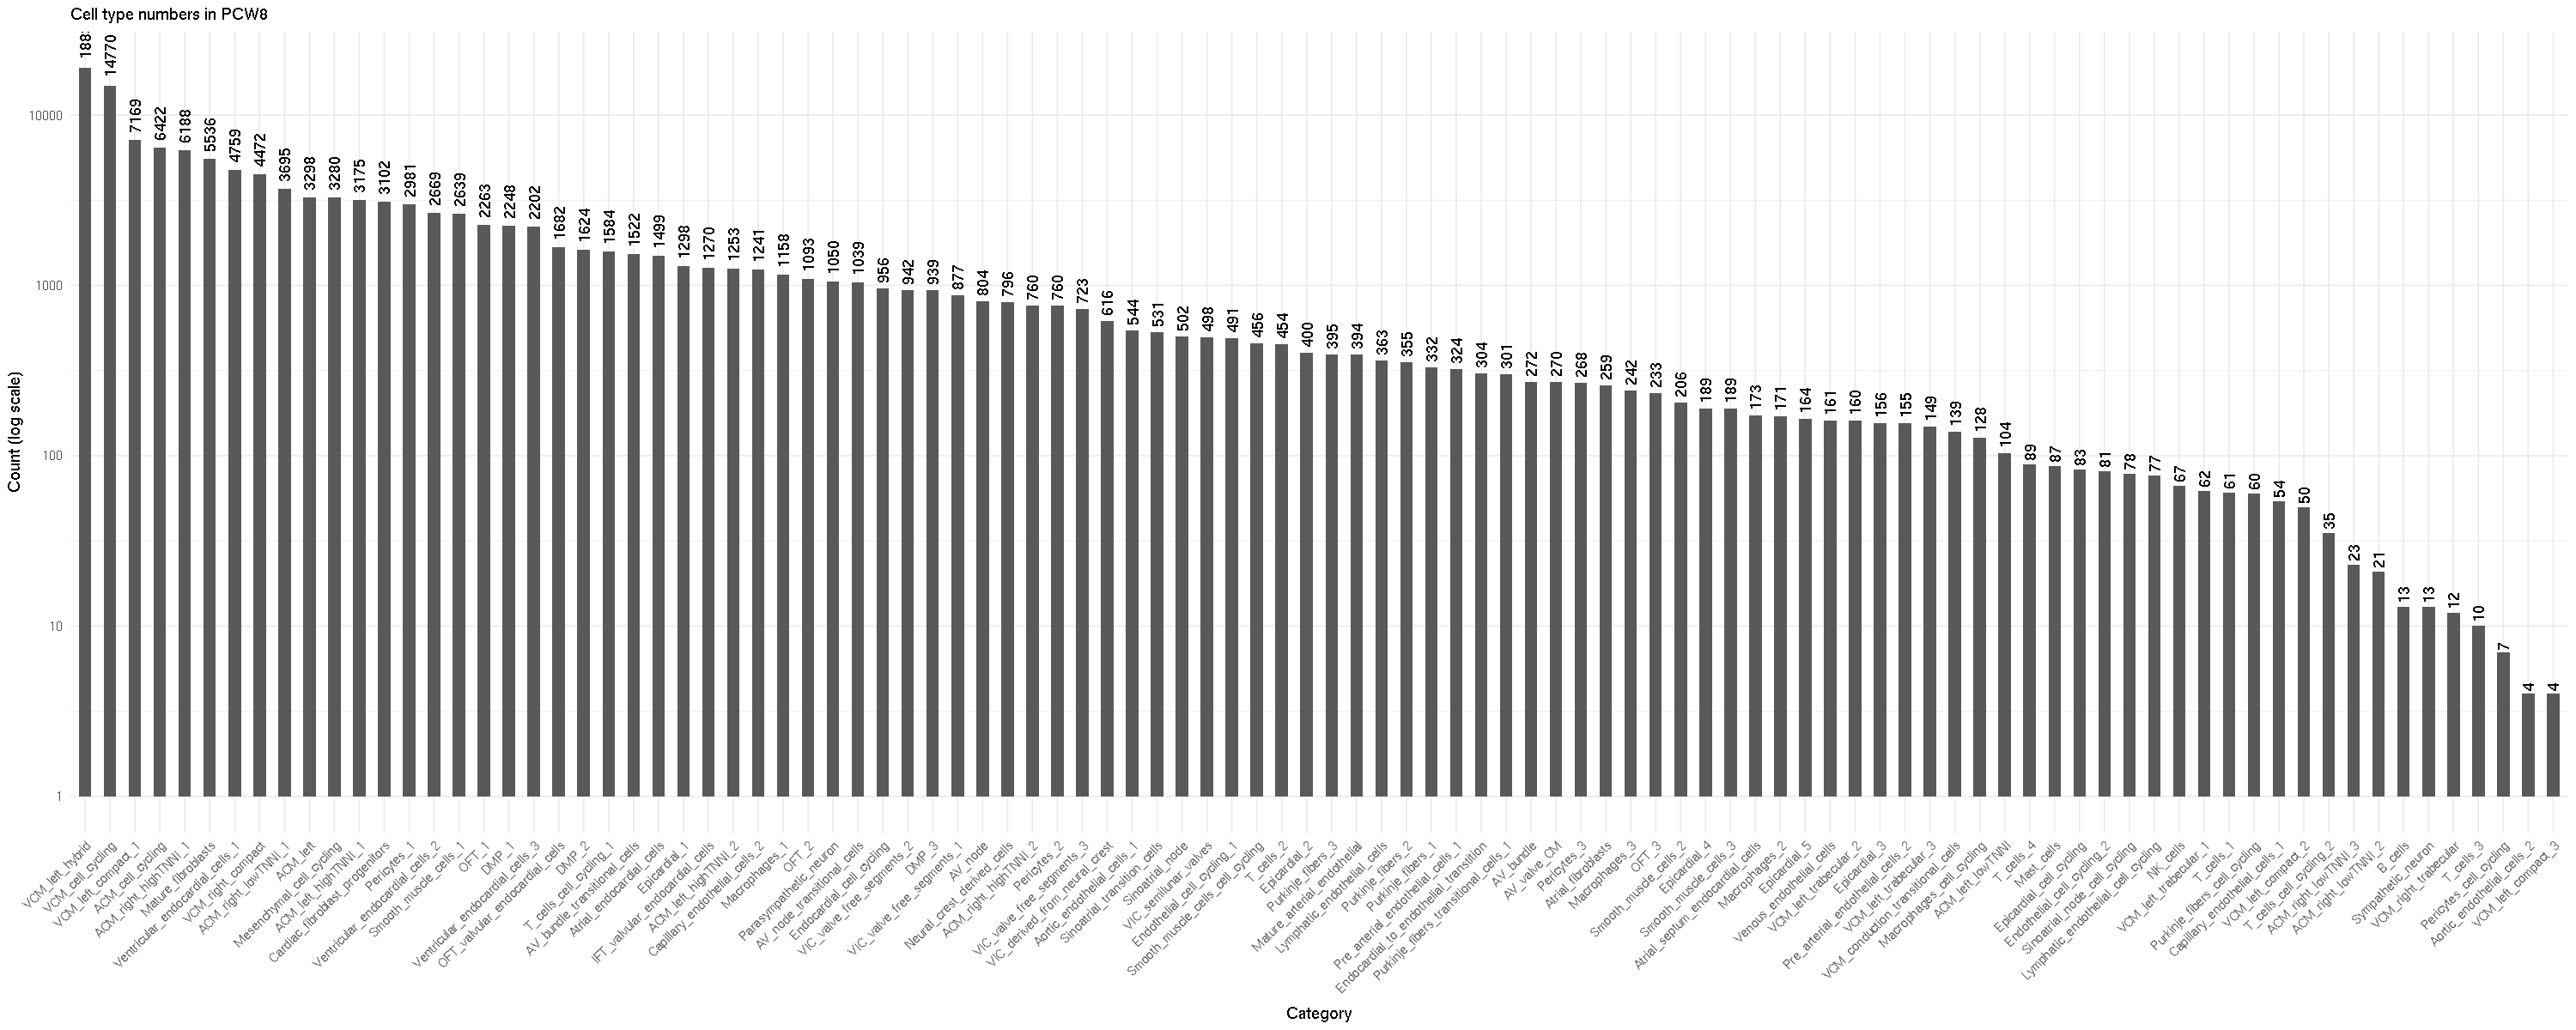

In [1]:
suppressPackageStartupMessages({
  library(ComplexHeatmap)
  library(circlize)
  library(CellChat)
})

o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

############################################################################################################################################
# get interaction matrix
############################################################################################################################################
cellchat = readRDS('/home/users/chensj16/s/analysis-proj/engreitz-lab/Preprocessing/cellchat.pcw8.RDS')

mat = cellchat@net$weight

counts = sort(table(cellchat@meta$New_Name), decreasing = T)
df = data.frame(counts)
colnames(df) <- c('Category','Value')

# Create the bar plot
o(25,10)
p = ggplot(df, aes(x = Category, y = Value)) + geom_bar(stat = 'identity', width = 0.5) +
  geom_text(aes(label = Value), vjust = 0.5, hjust=-0.2 ,angle = 90) +
  scale_y_log10() + theme_minimal() + theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) + labs(title = "Bar Plot of Counts", x = "Category", y = "Count (log scale)") +ggtitle('Cell type numbers in PCW8')

print(p)

# Filtering pathways by strength

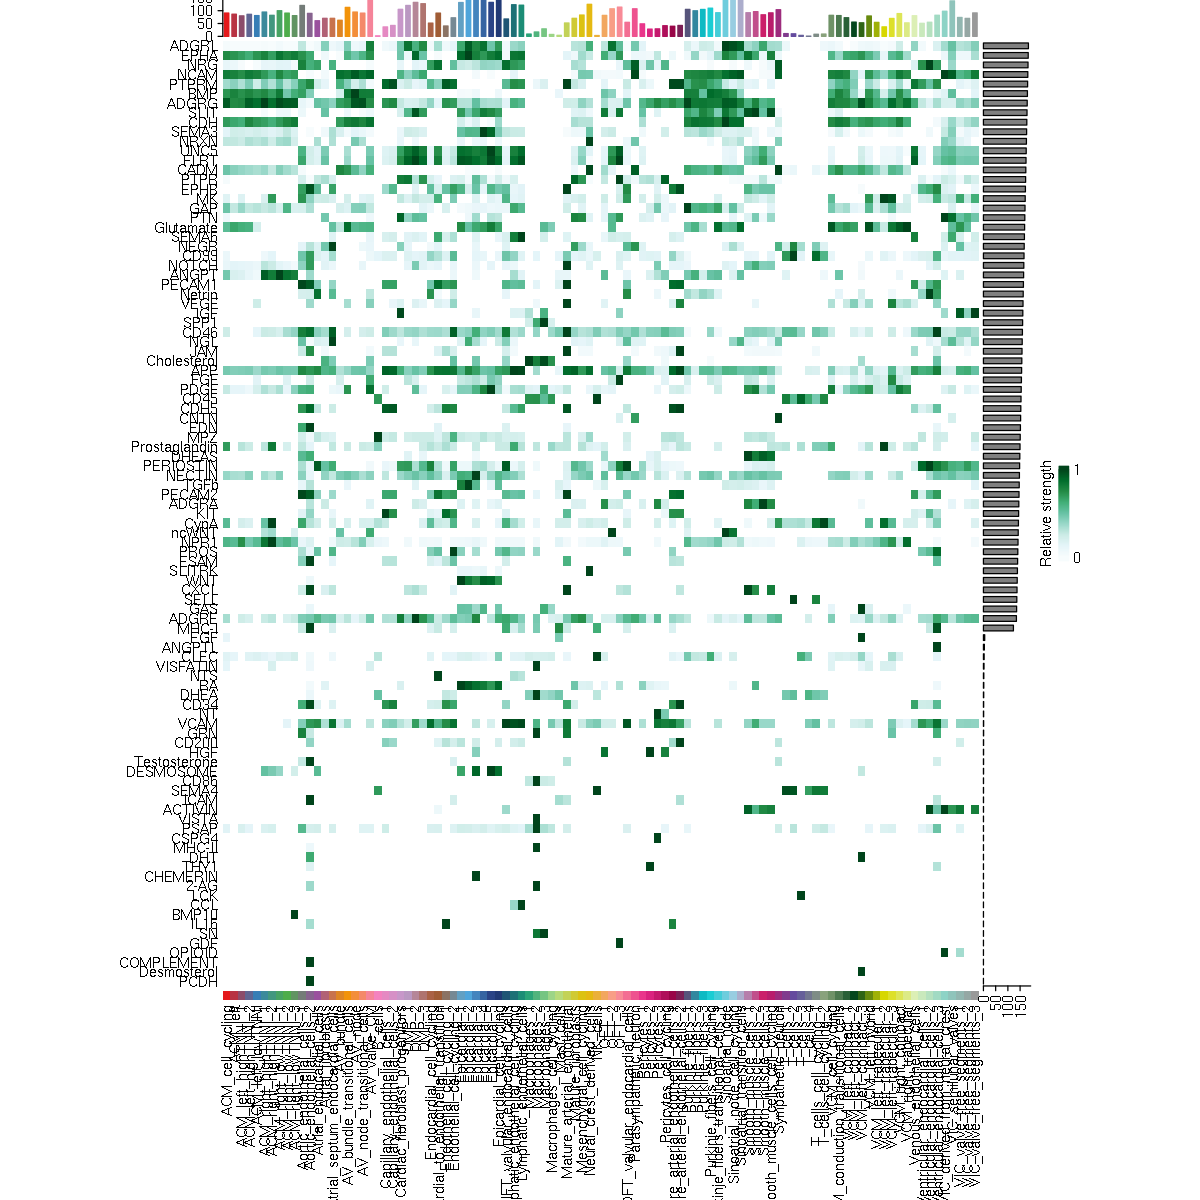

In [39]:
ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing", width = 16, height=20)
o(10,10)
print(ht1)


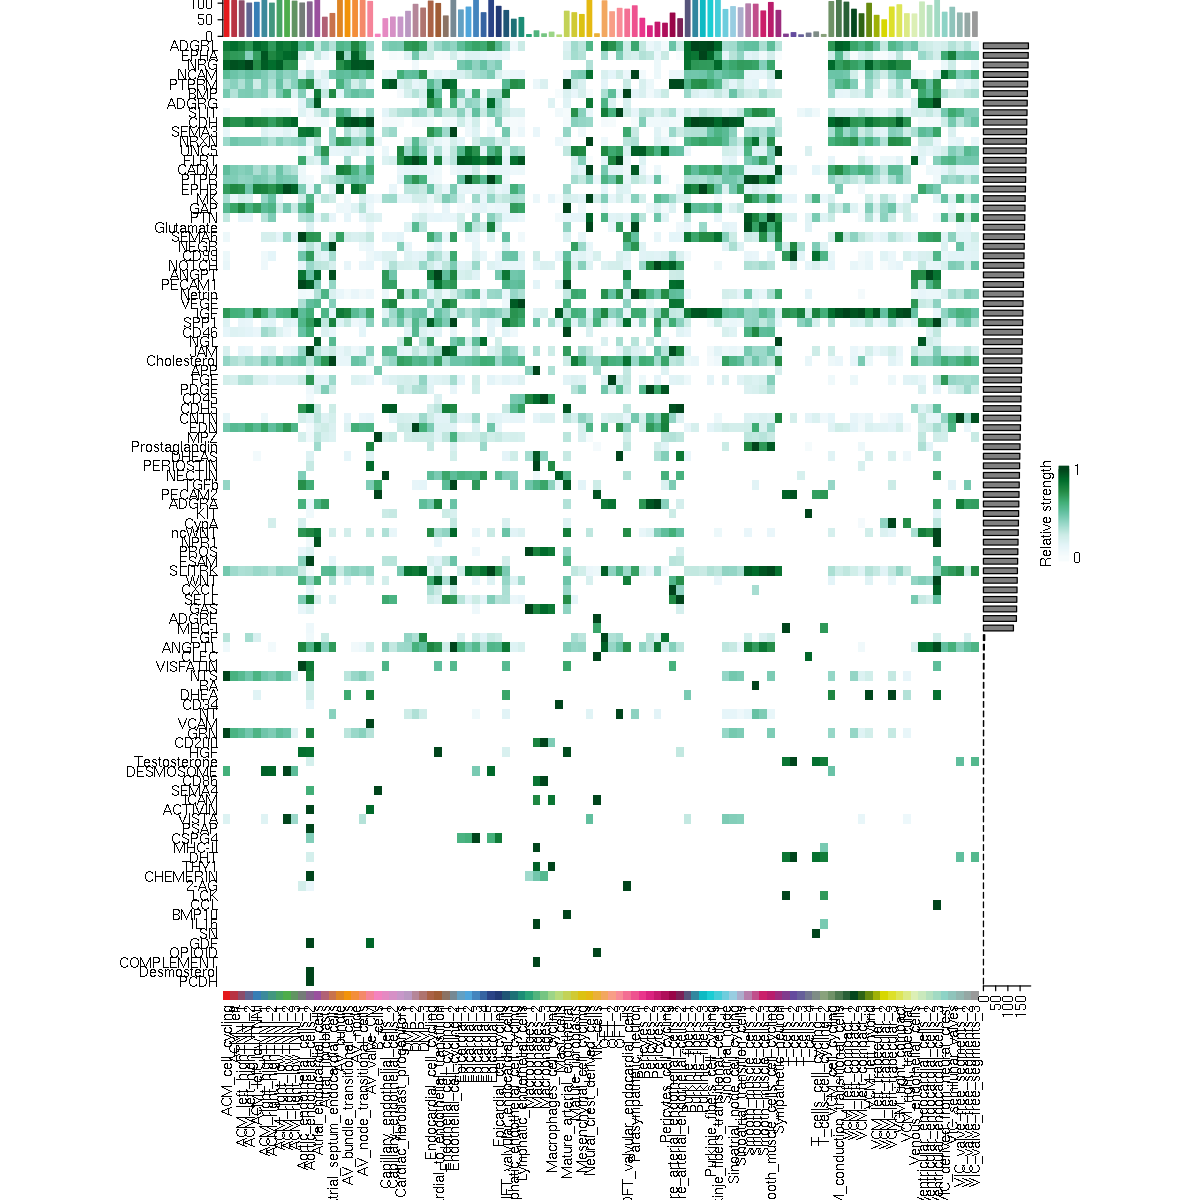

In [40]:
ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming", width = 16, height=20)
o(10,10)
print(ht2)

In [79]:
genes = rownames(ht1@matrix)
strength_annotation <- ht1@right_annotation@anno_list$Strength
env <- strength_annotation@fun@var_env
strengths <- as.numeric(get("value", envir = env))
outgoing.interaction.strengths <- data.frame(strengths, row.names = genes)

genes = rownames(ht2@matrix)
strength_annotation <- ht2@right_annotation@anno_list$Strength
env <- strength_annotation@fun@var_env
strengths <- as.numeric(get("value", envir = env))
incoming.interaction.strengths <- data.frame(strengths, row.names = genes)

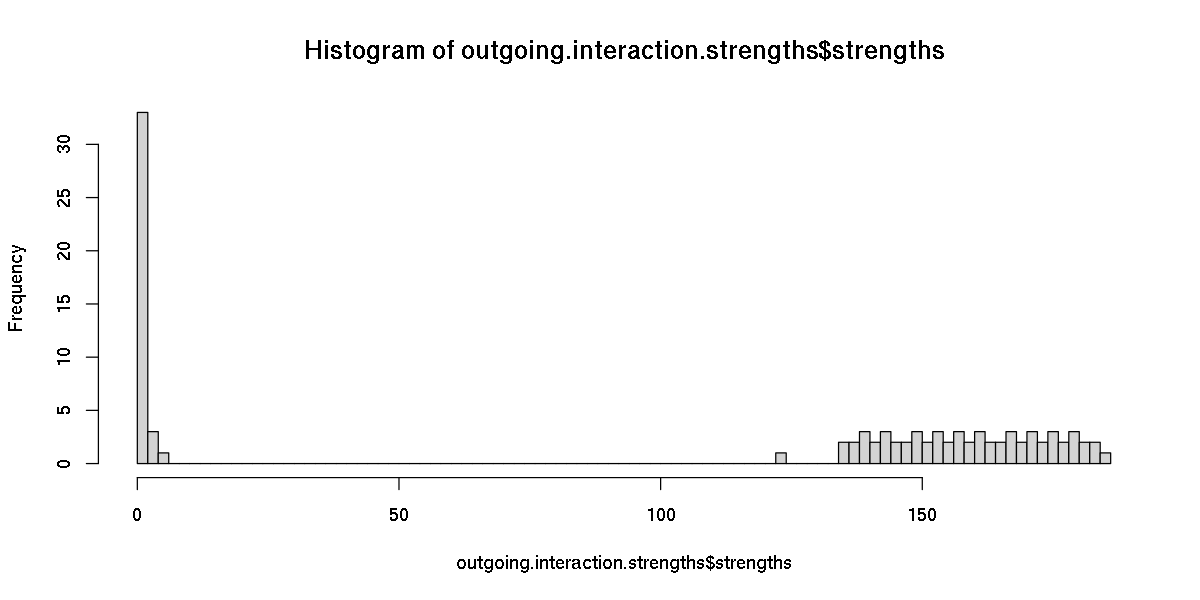

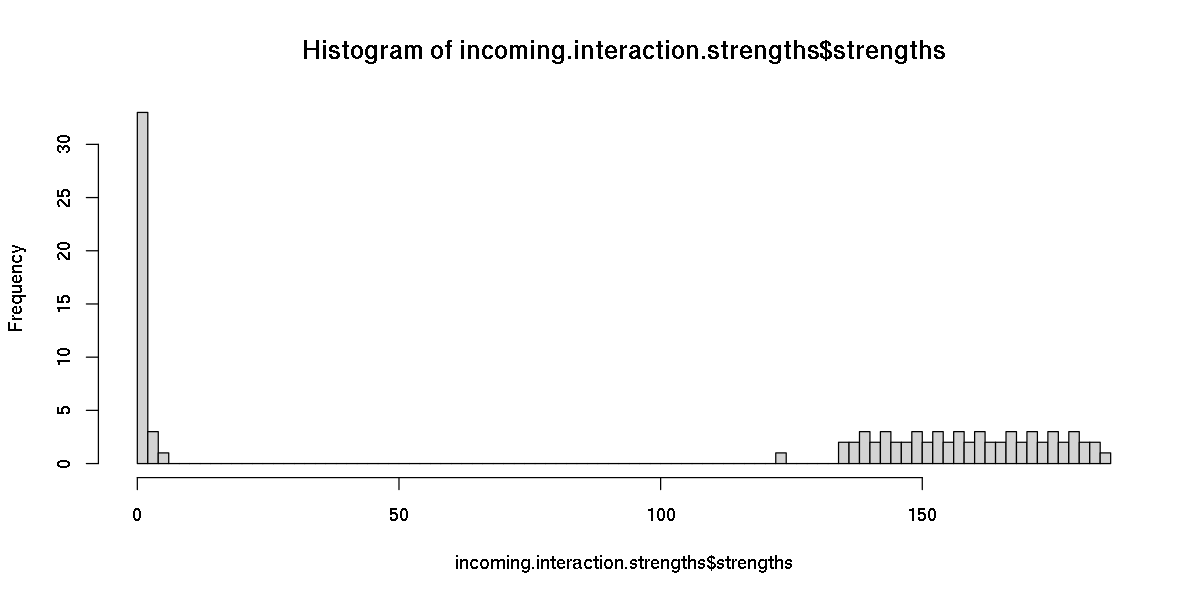

In [81]:
o(10,5)
hist(outgoing.interaction.strengths$strengths, breaks = 100)

hist(incoming.interaction.strengths$strengths, breaks = 100)

In [86]:
cci.pathways.selected <- unique(c(
    outgoing.interaction.strengths %>% filter(strengths>100) %>% rownames,
    incoming.interaction.strengths %>% filter(strengths>100) %>% rownames
))

# get strengths

ACM                 VCM CoreConductionCells   TzConductionCells 
          "#7ec0ee"           "#F0E68C"           "#DA70D6"           "#7B68EE" 
   EndocardialCells    EndothelialCells 
          "#00FF00"           "#FF7F00"

ACM_left_highTNNI_1  ACM_left_highTNNI_2             ACM_left 
           "#87CEEB"            "#000080"            "#4169E1" 
    ACM_left_lowTNNI ACM_right_highTNNI_1 ACM_right_highTNNI_2 
           "#00FF00"            "#228B22"            "#96DED1"

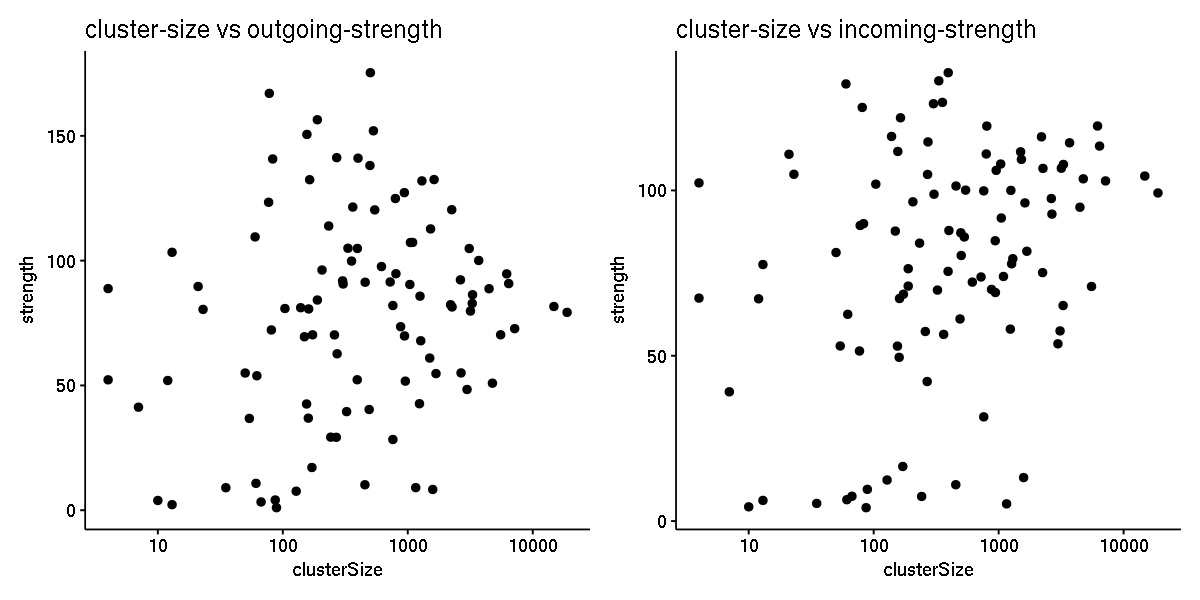

In [6]:
####################################################
# get interaction matrix
row_sums <- rowSums(mat)
col_sums <- colSums(mat)
cluster.size.vs.strength <- merge(x=df, y=data.frame(row_sums), by.x = 'Category', by.y='row.names') %>% rename(clusterSize =Value, strength=row_sums )
g1=ggpubr::ggscatter(cluster.size.vs.strength, x='clusterSize', y='strength' )&scale_x_log10()&ggtitle('cluster-size vs outgoing-strength')

cluster.size.vs.strength <- merge(x=df, y=data.frame(col_sums), by.x = 'Category', by.y='row.names')%>% rename(clusterSize =Value, strength=col_sums )
g2 = ggpubr::ggscatter(cluster.size.vs.strength, x='clusterSize', y='strength' )&scale_x_log10()&ggtitle('cluster-size vs incoming-strength')

o(10,5)
g1+g2


coi = names(counts[counts>=100])
mat = mat[coi, coi]


############################################################################################################################################
# Set colors for heatmap values and annotations
############################################################################################################################################
cm.major        <- read.csv('/home/users/chensj16/s/analysis-proj/engreitz-lab/Preprocessing/Items2Include - CelltypeList.v09162024.csv') %>% head(-1) %>% select(Plot_label, HexColorCode) %>% unique %>% pull(HexColorCode)
names(cm.major) <- read.csv('/home/users/chensj16/s/analysis-proj/engreitz-lab/Preprocessing/Items2Include - CelltypeList.v09162024.csv') %>% head(-1) %>% select(Plot_label, HexColorCode) %>% unique %>% pull(Plot_label)

cm.fine        <- read.csv('/home/users/chensj16/s/analysis-proj/engreitz-lab/Preprocessing/Items2Include - CelltypeList.v09162024.csv') %>% head(-1) %>% select(New_Name, CelltypeColor) %>% unique %>% pull(CelltypeColor)
names(cm.fine) <- read.csv('/home/users/chensj16/s/analysis-proj/engreitz-lab/Preprocessing/Items2Include - CelltypeList.v09162024.csv') %>% head(-1) %>% select(New_Name, CelltypeColor) %>% unique %>% pull(New_Name)

head(cm.major)
head(cm.fine)

############################################################################################################################################

# Define the color function
# The function maps 0 to white and smoothly transitions from white to the YlOrRd palette for positive values
color_fun <- colorRamp2(
  c(0.01, max(mat)*.2, max(mat)*.4, max(mat)*.6, max(mat)*1.),  # Breakpoints in the data values
  c("white", "#FFFFCCFF","#FEB24CFF","#FC4E2AFF","#800026FF")  # Corresponding colors: white for 0, light yellow for low values, and red for high values
)


In [87]:
height =30
width = 30
object= cellchat
pcw = 'pcw8'
pattern = "all"
signaling = cci.pathways.selected
slot.name = "netP"
color.use = cm.major
color.heatmap = "YlOrRd"
replace.NA= F
title = NULL
font.size = 8
font.size.title = 10
cluster.rows = T
cluster.cols = T
coi = coi
# ================================================================================================
# ======================== Check if centrality scores have been computed ========================
# ================================================================================================
if (length(slot(object, slot.name)$centr) == 0) {
  stop("Please run `netAnalysis_computeCentrality` to compute the network centrality scores! ")
}

# ================================================================================================
# ======================== Extract centrality scores and prepare matrices ========================
# ================================================================================================
centr <- slot(object, slot.name)$centr
outgoing <- matrix(0, nrow = nlevels(object@idents), ncol = length(centr))
incoming <- matrix(0, nrow = nlevels(object@idents), ncol = length(centr))
dimnames(outgoing) <- list(levels(object@idents), names(centr))
dimnames(incoming) <- dimnames(outgoing)
for (i in 1:length(centr)) {
  outgoing[,i] <- centr[[i]]$outdeg
  incoming[,i] <- centr[[i]]$indeg
}

# ================================================================================================
# Determine the pattern type and set up the matrix
# ================================================================================================
if (pattern == "outgoing") {
  mat <- t(outgoing)
  legend.name <- "Outgoing"
} else if (pattern == "incoming") {
  mat <- t(incoming)
  legend.name <- "Incoming"
} else if (pattern == "all") {
  mat <- t(outgoing+ incoming)
  legend.name <- "Overall"
}

# ================================================================================================
# Set up the title
# ================================================================================================
if (is.null(title)) {
  title <- paste0(legend.name, " signaling patterns")
} else {
  title <- paste0(paste0(legend.name, " signaling patterns"), " - ",title)
}

# ================================================================================================
# Filter signaling pathways if specified
# ================================================================================================
if (!is.null(signaling)) {
  mat1 <- mat[rownames(mat) %in% signaling, , drop = FALSE]
  mat <- matrix(0, nrow = length(signaling), ncol = ncol(mat))
  idx <- match(rownames(mat1), signaling)
  mat[idx[!is.na(idx)], ] <- mat1
  dimnames(mat) <- list(signaling, colnames(mat1))
}

# ================================================================================================
# Further matrix processing
# ================================================================================================
mat = mat[ ,coi] # subset to cell types of interests (optional) 
mat = mat[rowSums(mat) != 0, ]
mat.ori <- mat
mat <- sweep(mat, 1L, apply(mat, 1, max), '/', check.margin = FALSE)
if (replace.NA){
  mat[mat == 0] <- NA  
}

# ================================================================================================
# Set up colors
# ================================================================================================
if (is.null(color.use)) {
  color.use <- scPalette(length(colnames(mat)))
}
color.heatmap.use <- grDevices::colorRampPalette((RColorBrewer::brewer.pal(n = 9, name = color.heatmap)))(50)

# ================================================================================================
# Flip the matrix
# ================================================================================================
mat <- t(mat)




# Make heatmaps

In [88]:
# ================================================================================================
# Make annotations 
# ================================================================================================
# Prepare annotation data
df = cellchat@meta %>% select(New_Name, Plot_label) %>% unique %>% filter(New_Name %in% rownames(mat)) %>% arrange(match(New_Name, rownames(mat)))
rownames(df) <- df$New_Name
df$New_Name <- NULL
row_annotation <- rowAnnotation(df = df, col = list(Plot_label = cm.major), #which = "column",
                                show_legend = T, show_annotation_name = FALSE,
                                simple_anno_size = grid::unit(0.8, "cm"))

# Set up legend breaks
if (min(mat, na.rm = T) == max(mat, na.rm = T)) {
    legend.break <- max(mat, na.rm = T)
} else {
    legend.break <- c(round(min(mat, na.rm = T), digits = 1), round(max(mat, na.rm = T), digits = 1))
}


In [ ]:
# ================================================================================================
# Build Heatmap
# ================================================================================================
ht1 = Heatmap(mat, col = color.heatmap.use, 
              na_col = "white", name = "Relative strength", border=T,
              show_row_names = F,
              row_km=4, column_km=7,
              left_annotation = row_annotation, 
              #right_annotation= ha2, #top_annotation =ha1,  #bottom_annotation = col_annotation, top_annotation = ha2, right_annotation = ha1, #cluster_rows = cluster.rows, cluster_columns = cluster.rows,
              cluster_rows=T, cluster_columns=T, cluster_column_slices=T,
              row_names_side = "right", row_names_rot = 0, row_names_gp = gpar(fontsize = font.size),
              column_names_gp = gpar(fontsize = font.size),
              width = unit(width, "cm"), height = unit(height, "cm"),
              column_title = title, 
              column_title_gp = gpar(fontsize = font.size.title),
              column_names_rot = 45,
              heatmap_legend_param = list(title_gp = gpar(fontsize = 8, fontface = "plain"), title_position = "leftcenter-rot",
                                          border = NA, #at = legend.break,
                                          legend_height = unit(20, "mm"),labels_gp = gpar(fontsize = 8),grid_width = unit(2, "mm") )
             )

# ================================================================================================
# Draw Heatmap
# ================================================================================================


o(width/2, height/2)
my_gpar <- gpar(fontfamily = "DejaVu Sans"); pushViewport(viewport(gp = my_gpar));
ht1 = draw(ht1, show_heatmap_legend = T, 
     heatmap_legend_side = "left" ,# legend_direction = "horizontal",
     annotation_legend_side = "bottom", padding = unit(c(20, 30, 20, 30), "mm"), #下左上右
     merge_legend = TRUE)
popViewport();


cairo_pdf(filename = paste('CCI-incoming-outgoing-celltype-clustering',pcw,'pdf',sep='.'), width = width, height = height)
    pushViewport(viewport(gp = my_gpar));
    ht1 = draw(ht1, show_heatmap_legend = T,
         heatmap_legend_side = "right" ,# legend_direction = "horizontal",
         annotation_legend_side = "bottom", padding = unit(c(60, 30, 60, 30), "mm"), #下左上右
         merge_legend = TRUE)
    popViewport();
dev.off()
